In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import argparse
import random
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import tqdm
import copy
from sklearn.metrics import precision_recall_curve, f1_score


from dataset_helper_functions import *
from sklearn.preprocessing import StandardScaler
import MLPClassifier


%load_ext autoreload
%autoreload 2

SAVE_MODEL = True
TRAIN_MODE = True
REMOVE_FREETHROWS_DATASET = False
REMOVE_FREETHROWS_MODEL = False

RANDOM_SPLIT = False

data = "/Users/galishai/PycharmProjects/AI_PROJECT_SPORTS_HIGHLIGHTS/full season data/plays_with_onehot_v2_withoutOT.csv"
is_tuning = False
folds = 0
epochs = 50
batch_size = 2048
hidden_dim = 256
dropout = 0.3
lr = 1e-04
seed = 42
thresholds = [0.1, 0.15,0.2,0.25]
betas = [0.5, 1.0, 2.0]

freeze_seeds(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: mps


# MLP TRAINING

## Data loading

In [10]:
dataset = pd.read_csv(data)

In [11]:

freeze_seeds(seed)

base = add_game_ids(dataset)

games_idx = base['game_id'].unique()

rng = np.random.default_rng(seed=seed)  # For reproducibility
shuffled_game_ids = rng.permutation(games_idx)
#shuffled_game_ids

split_idx = int(0.8 * len(shuffled_game_ids))
train_game_ids = shuffled_game_ids[:split_idx]
test_game_ids = shuffled_game_ids[split_idx:]
split_test_ids = int(0.5 * len(test_game_ids))
val_game_ids = test_game_ids[:split_test_ids]
test_game_ids = test_game_ids[split_test_ids:]
print(len(train_game_ids))
print(len(val_game_ids))

train_df = base[base['game_id'].isin(train_game_ids)].copy()
val_df   = base[base['game_id'].isin(val_game_ids)].copy()
test_df  = base[base['game_id'].isin(test_game_ids)].copy()

val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#ONLY for TRAIN
sp_map = build_star_power_mapping(train_df)

train_df = get_dataset(train_df, play_context_window=3, team_context_window=3, compact_players=True, star_power_mapping=sp_map)
val_df = get_dataset(val_df, play_context_window=3,team_context_window=3,compact_players=True, star_power_mapping=sp_map)
test_df = get_dataset(test_df, play_context_window=3,team_context_window=3,compact_players=True, star_power_mapping=sp_map)

feature_cols = [c for c in train_df.columns if c not in LABEL_COLS]
train_df = align_to_train(train_df, feature_cols)
val_df = align_to_train(val_df, feature_cols)
test_df = align_to_train(test_df, feature_cols)

X_train = train_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
y_train = train_df['is_highlight'].to_numpy(dtype=np.int32)
X_val = val_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
y_val = val_df['is_highlight'].to_numpy(dtype=np.int32)
X_test = test_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
y_test = test_df['is_highlight'].to_numpy(dtype=np.int32)

scaler = StandardScaler().fit(X_train)

X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test = scaler.transform(X_test)

train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(y_train).long())
val_ds = TensorDataset(torch.from_numpy(X_val).float(),
                         torch.from_numpy(y_val).long())

n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight_val = float(n_neg/n_pos)
pos_weight = torch.tensor(pos_weight_val, device=device, dtype=torch.float32)
#sample_weights = np.where(y_train == 1, pos_weight_val, 1.0).astype(np.float32)

#weights_tensor = torch.from_numpy(sample_weights)
#sampler = WeightedRandomSampler(weights_tensor,
 #                               num_samples=len(weights_tensor),
 #                               replacement=True)


764
95


In [12]:
pos_weight
if isinstance(pos_weight, torch.Tensor):
    pos_weight = pos_weight.to(device)

## Feature Selection

In [13]:
pos_weight

tensor(17.0506, device='mps:0')

## End feature selection

In [14]:
def find_best_threshold(y_true, y_prob):
    # fast coarse-to-fine search
    ts = np.linspace(0.01, 0.99, 99)
    scores = [f1_score(y_true, (y_prob>=t).astype(int)) for t in ts]
    t = ts[int(np.argmax(scores))]
    # refine around peak
    fine = np.linspace(max(0.01, t-0.05), min(0.99, t+0.05), 101)
    scores2 = [f1_score(y_true, (y_prob>=t).astype(int)) for t in fine]
    return fine[int(np.argmax(scores2))]

def evaluate_imbalanced(
    model,
    loader,
    device,
    beta: float = 1.0,
    thr_grid: np.ndarray = np.linspace(0, 1, 101),
):
    """
    Runs `model` on `loader` and finds the threshold in `thr_grid` that maximizes F_beta.
    Returns: {
      "best_threshold": float,
      "metrics_at_best": { accuracy, precision, recall, f1, roc_auc, pr_auc, confusion_matrix },
      "all_thresholds": np.ndarray,
      "f_beta_scores": np.ndarray  # same shape as thr_grid
    }
    """

    # 1) Collect truth & probs
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            ys.extend(yb.cpu().numpy())
            ps.extend(probs.cpu().numpy())

    y_true = np.array(ys)
    y_prob = np.array(ps)

    # 2) Compute ROC-AUC and PR-AUC (threshold-independent)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc  = average_precision_score(y_true, y_prob)

    # 3) Sweep thresholds to find best F_beta
    precisions, recalls, _ = precision_recall_curve(y_true, y_prob)
    # We'll interpolate F_beta on our thr_grid instead of raw curve thresholds:
    f_beta_scores = []
    for thr in thr_grid:
        p = precision_score(y_true, y_prob >= thr, zero_division=0)
        r = recall_score   (y_true, y_prob >= thr, zero_division=0)
        f = (1 + beta**2) * (p * r) / (beta**2 * p + r + 1e-8)
        f_beta_scores.append(f)
    f_beta_scores = np.array(f_beta_scores)

    best_idx = f_beta_scores.argmax()
    best_thr = float(thr_grid[best_idx])

    # 4) Compute all metrics at best threshold
    y_pred = (y_prob >= best_thr).astype(int)
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist(),
    }

    return {
        "best_threshold": best_thr,
        "metrics_at_best": metrics,
        "all_thresholds": thr_grid,
        "f_beta_scores": f_beta_scores,
    }

## Hypertuning

In [15]:
param_grid = {
                'hidden_dims': [[256,128,128]],#[256,128],[256]],
                'dropout': [0],#,0.3],#[0.1,0.5],
                'lr': [1e-3],#,1e-4],
                'epochs': [50],
                'batch_size': [2048],
                'weight_decay': [0]
            }

{'batch_size': 2048, 'dropout': 0, 'epochs': 50, 'hidden_dims': [256, 128, 128], 'lr': 0.001, 'weight_decay': 0}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2653 | Val AP: 0.3102
Epoch 1 | Train loss: 0.9217 | Val loss: 0.5108


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2964 | Val AP: 0.3312
Epoch 2 | Train loss: 0.7846 | Val loss: 0.4191


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2817 | Val AP: 0.3253
Epoch 3 | Train loss: 0.7138 | Val loss: 0.4174
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2857 | Val AP: 0.3163
Epoch 4 | Train loss: 0.6473 | Val loss: 0.4146
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2944 | Val AP: 0.3208
Epoch 5 | Train loss: 0.5797 | Val loss: 0.4087
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2948 | Val AP: 0.2976
Epoch 6 | Train loss: 0.5159 | Val loss: 0.4228
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.3074 | Val AP: 0.2610
Epoch 7 | Train loss: 0.4630 | Val loss: 0.3864
no auprc improvement for 5 epoch(s).


epoch: 8:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8 | Val F1: 0.3346 | Val AP: 0.2977
Epoch 8 | Train loss: 0.4240 | Val loss: 0.3666
no auprc improvement for 6 epoch(s).


epoch: 9:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9 | Val F1: 0.3319 | Val AP: 0.2520
Epoch 9 | Train loss: 0.3875 | Val loss: 0.3626
no auprc improvement for 7 epoch(s).


epoch: 10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10 | Val F1: 0.3340 | Val AP: 0.2499
Epoch 10 | Train loss: 0.3454 | Val loss: 0.3784
no auprc improvement for 8 epoch(s).


epoch: 11:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11 | Val F1: 0.3384 | Val AP: 0.2451
Epoch 11 | Train loss: 0.3183 | Val loss: 0.4017
no auprc improvement for 9 epoch(s).


epoch: 12:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 12 | Val F1: 0.3409 | Val AP: 0.2418
Epoch 12 | Train loss: 0.2933 | Val loss: 0.4036
no auprc improvement for 10 epoch(s).
early stopping at epoch 12.
saved checkpoint saved_model/mlp_tuned.pth


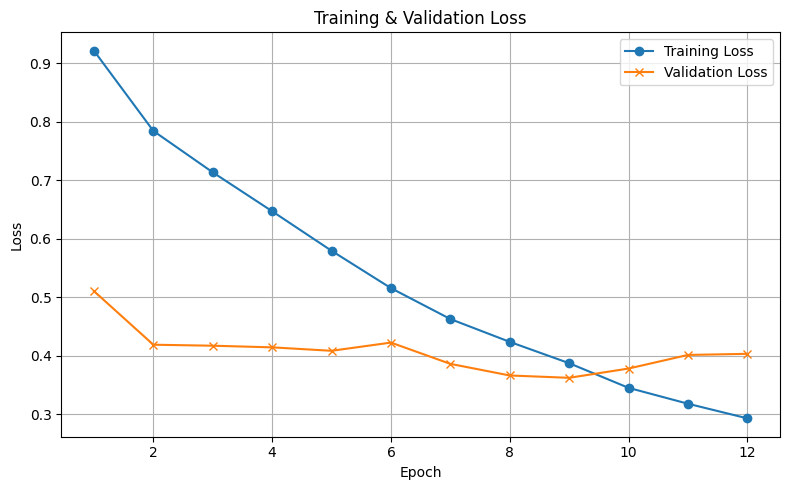

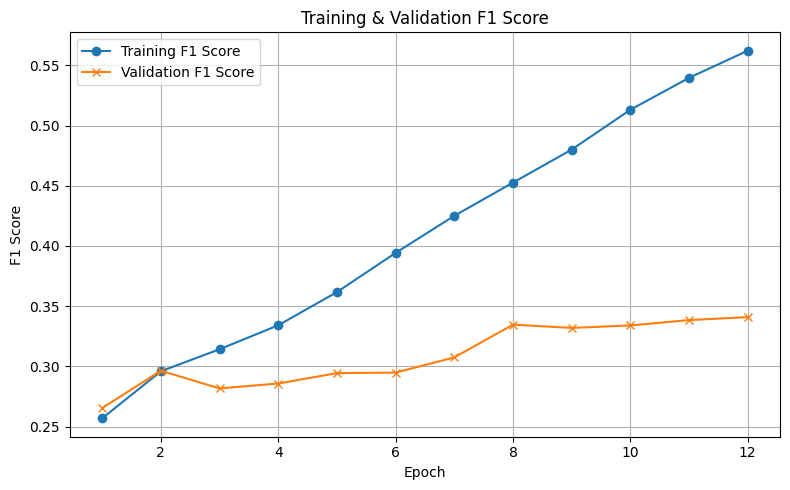

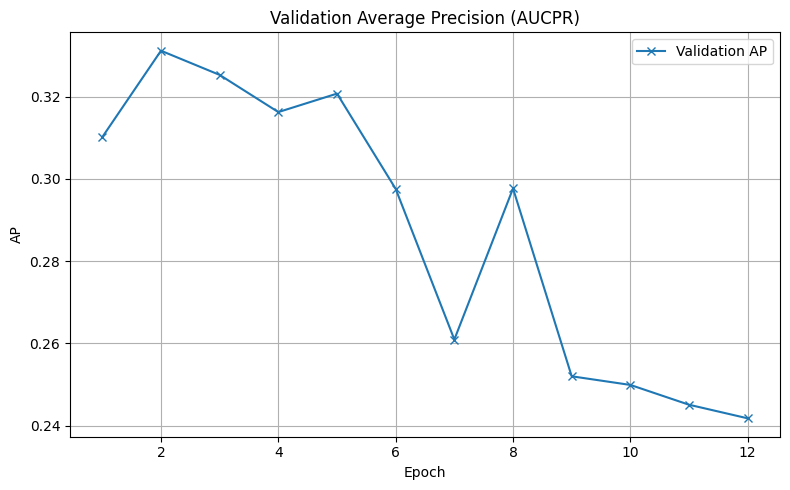

{'batch_size': 2048, 'dropout': 0, 'epochs': 50, 'hidden_dims': [256, 128, 128], 'lr': 0.001, 'weight_decay': 0}
→ Best threshold: 0.80
accuracy    : 0.906632106834958
precision   : 0.3004653868528214
recall      : 0.5319258496395468
f1          : 0.38401486988847583
roc_auc     : 0.874056623667178
pr_auc      : 0.3311894864032733
confusion_matrix: [[31147, 2405], [909, 1033]]


In [16]:
results = []

generator = torch.Generator().manual_seed(seed)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, generator=generator)
val_loader   = DataLoader(val_ds, batch_size=2048, shuffle=False)

for params in ParameterGrid(param_grid):
    freeze_seeds(seed)
    print(params)
    model = MLPClassifier.MLPClassifier(input_dim=X_train.shape[1], hidden_dims=params['hidden_dims'], dropout=params['dropout']).to(device)

    model = MLPClassifier.train_fold(model=model, train_loader=train_loader, val_loader=val_loader, device=device, epochs=params['epochs'], lr=params['lr'], pos_weight=pos_weight, min_delta=0, save_model=SAVE_MODEL, rm_ft_ds=REMOVE_FREETHROWS_DATASET, weight_decay=params['weight_decay'], patience=10, objective="auprc")

    result = evaluate_imbalanced(model=model,
                              loader=val_loader,
                              device=device,
                              beta=1.0,
                              thr_grid=np.linspace(0,1,201),)

    results.append(result)

for result, params in zip(results,ParameterGrid(param_grid)) :
    print(params)
    print(f"→ Best threshold: {result['best_threshold']:.2f}")
    for name, val in result["metrics_at_best"].items():
        print(f"{name:12s}: {val}")



In [ ]:
for result, params in zip(results,ParameterGrid(param_grid)) :
    print(params)
    print(f" Best threshold: {result['best_threshold']:.2f}")
    for name, val in result["metrics_at_best"].items():
        print(f"{name:12s}: {val}")

In [ ]:


model = MLPClassifier(input_dim=X.shape[1], hidden_dim=hidden_dim, dropout=dropout).to(device)
print("Training Model")
model = train_fold(model, train_loader, val_loader, device, epochs, lr, pos_weight=pos_weight, min_delta=0, save_model=SAVE_MODEL, rm_ft_ds=REMOVE_FREETHROWS_DATASET, patience=10)

In [ ]:
print(pos_weight)

In [ ]:
results = evaluate_imbalanced(model=model,
                              loader=val_loader,
                              device=device,
                              beta=1.0,
                              thr_grid=np.linspace(0,1,201),)

print(f" Best threshold: {results['best_threshold']:.2f}")
for name, val in results["metrics_at_best"].items():
    print(f"{name:12s}: {val}")

# Feature Engineering Hypertuning

## Feature Selection

In [13]:
base_params = {
                'hidden_dims': [256,128,128],
                'dropout': [0],
                'lr': [1e-3],
                'epochs': [40],
                'batch_size': [2048],
                'weight_decay': [0],
                'context_window_size': [3],
            }

bool_flags = [
                'compact_players',
                'compact_oncourt',
                'compact_current_team',
                'drop_home_away_teams',
                'group_all_plays',
                'enum_quarters',
                ]

param_grid = []
if len(base_params['context_window_size']) > 1:
    for window_size in base_params['context_window_size']:
        param = {key: val[0] for key, val in base_params.items()}
        param['hidden_dims'] = base_params['hidden_dims']
        param['context_window_size'] = window_size
        for b in bool_flags:
            param[b]=False
        param_grid.append(param)
else:
    param = {key: val[0] for key, val in base_params.items()}
    param['hidden_dims'] = base_params['hidden_dims']
    for b in bool_flags:
        param[b]=False
    param_grid.append(param)

for b in bool_flags:
    param = {key: val[0] for key, val in base_params.items()}
    param['hidden_dims'] = base_params['hidden_dims']
    for i in bool_flags:
        if i == b:
            param[i] = True
        else:
            param[i] = False
    param_grid.append(param)

param_grid

[{'hidden_dims': [256, 128, 128],
  'dropout': 0,
  'lr': 0.001,
  'epochs': 40,
  'batch_size': 2048,
  'weight_decay': 0,
  'context_window_size': 3,
  'compact_players': False,
  'compact_oncourt': False,
  'compact_current_team': False,
  'drop_home_away_teams': False,
  'group_all_plays': False,
  'enum_quarters': False},
 {'hidden_dims': [256, 128, 128],
  'dropout': 0,
  'lr': 0.001,
  'epochs': 40,
  'batch_size': 2048,
  'weight_decay': 0,
  'context_window_size': 3,
  'compact_players': True,
  'compact_oncourt': False,
  'compact_current_team': False,
  'drop_home_away_teams': False,
  'group_all_plays': False,
  'enum_quarters': False},
 {'hidden_dims': [256, 128, 128],
  'dropout': 0,
  'lr': 0.001,
  'epochs': 40,
  'batch_size': 2048,
  'weight_decay': 0,
  'context_window_size': 3,
  'compact_players': False,
  'compact_oncourt': True,
  'compact_current_team': False,
  'drop_home_away_teams': False,
  'group_all_plays': False,
  'enum_quarters': False},
 {'hidden_dims'

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': False}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2463 | Val AP: 0.2714
Epoch 1 | Train loss: 0.9533 | Val loss: 0.5482


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2755 | Val AP: 0.3159
Epoch 2 | Train loss: 0.7835 | Val loss: 0.4521


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2615 | Val AP: 0.2928
Epoch 3 | Train loss: 0.6976 | Val loss: 0.4441
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2815 | Val AP: 0.2837
Epoch 4 | Train loss: 0.6222 | Val loss: 0.4092
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2893 | Val AP: 0.2852
Epoch 5 | Train loss: 0.5451 | Val loss: 0.3930
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.3023 | Val AP: 0.2640
Epoch 6 | Train loss: 0.4739 | Val loss: 0.3926
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.2997 | Val AP: 0.2188
Epoch 7 | Train loss: 0.4042 | Val loss: 0.4090
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


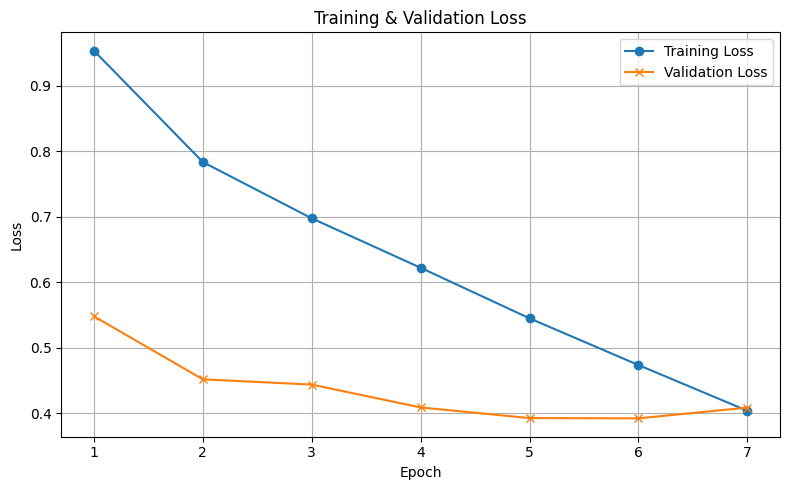

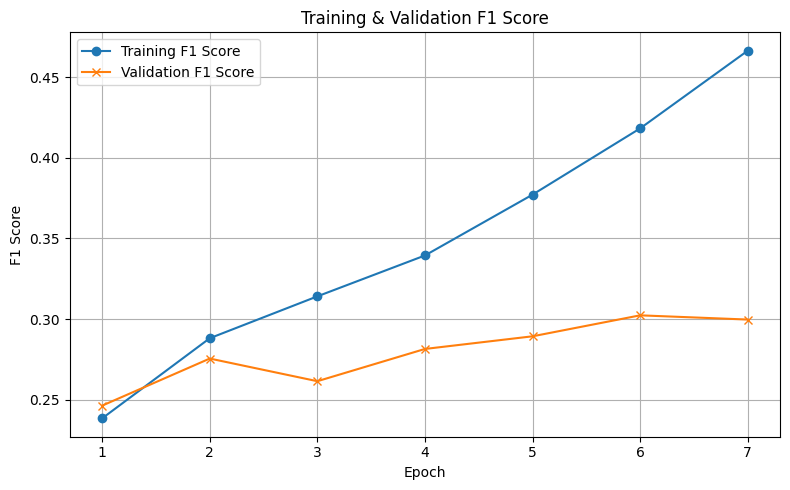

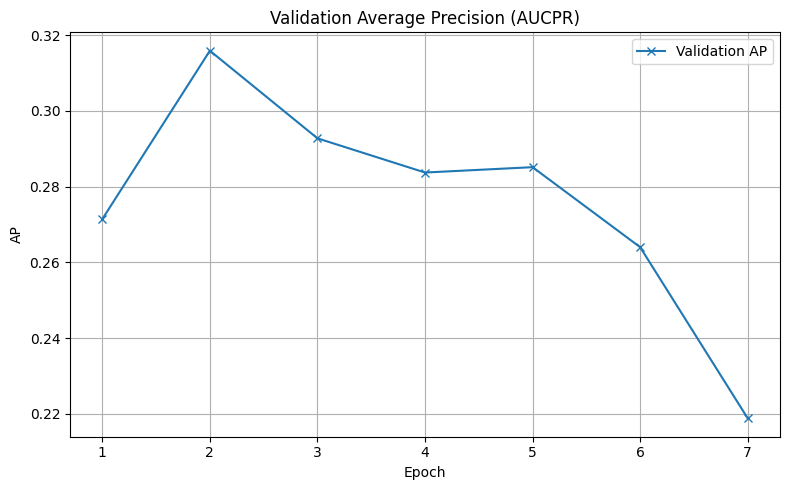

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': True, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': False}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2653 | Val AP: 0.3102
Epoch 1 | Train loss: 0.9217 | Val loss: 0.5108


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2964 | Val AP: 0.3312
Epoch 2 | Train loss: 0.7846 | Val loss: 0.4191


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2817 | Val AP: 0.3253
Epoch 3 | Train loss: 0.7138 | Val loss: 0.4174
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2857 | Val AP: 0.3163
Epoch 4 | Train loss: 0.6473 | Val loss: 0.4146
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2944 | Val AP: 0.3208
Epoch 5 | Train loss: 0.5797 | Val loss: 0.4087
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2948 | Val AP: 0.2976
Epoch 6 | Train loss: 0.5159 | Val loss: 0.4228
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.3074 | Val AP: 0.2610
Epoch 7 | Train loss: 0.4630 | Val loss: 0.3864
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


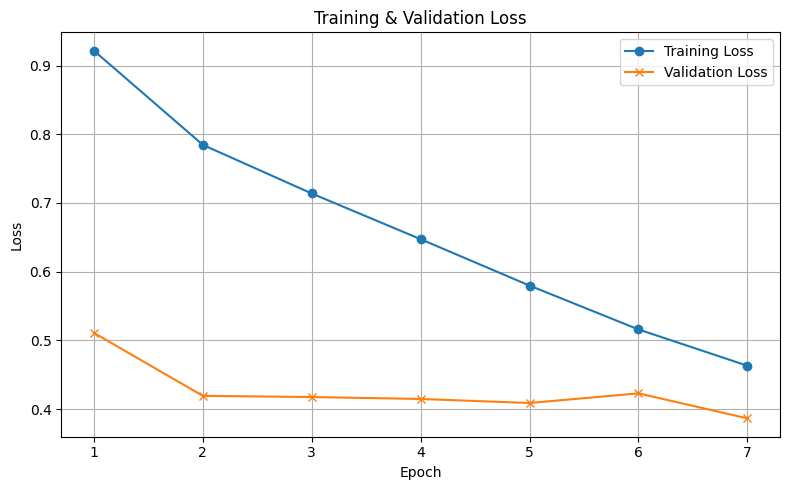

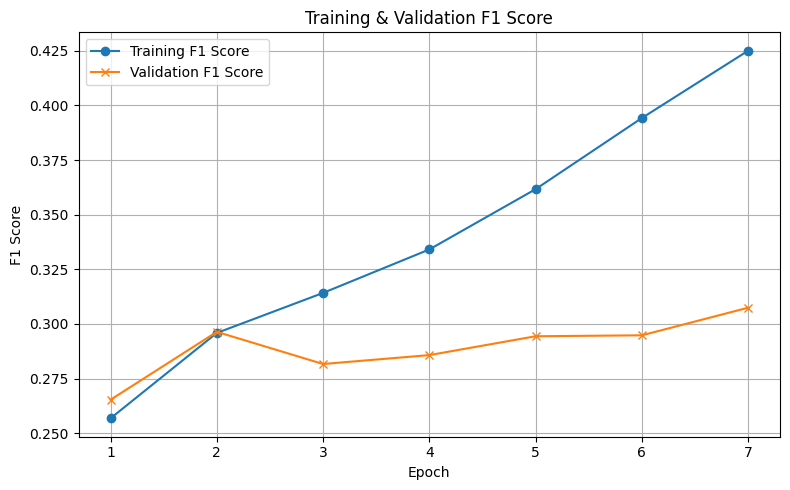

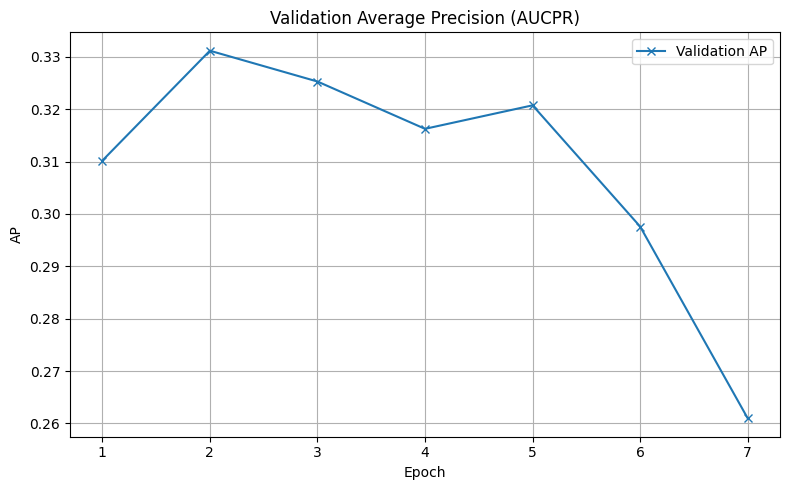

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': True, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': False}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2450 | Val AP: 0.2827
Epoch 1 | Train loss: 0.9491 | Val loss: 0.5483


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2811 | Val AP: 0.3086
Epoch 2 | Train loss: 0.7868 | Val loss: 0.4459


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2590 | Val AP: 0.2884
Epoch 3 | Train loss: 0.7019 | Val loss: 0.4440
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2858 | Val AP: 0.2926
Epoch 4 | Train loss: 0.6307 | Val loss: 0.4106
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2949 | Val AP: 0.2754
Epoch 5 | Train loss: 0.5521 | Val loss: 0.4003
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2833 | Val AP: 0.2520
Epoch 6 | Train loss: 0.4842 | Val loss: 0.4559
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.3169 | Val AP: 0.2508
Epoch 7 | Train loss: 0.4239 | Val loss: 0.3838
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


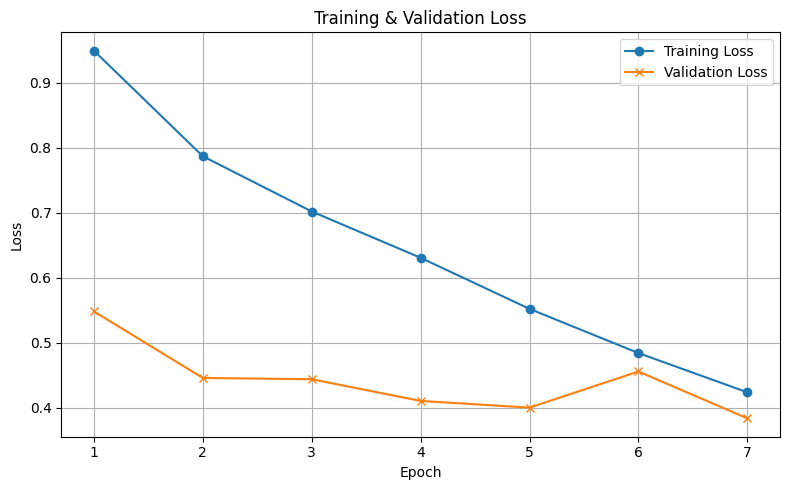

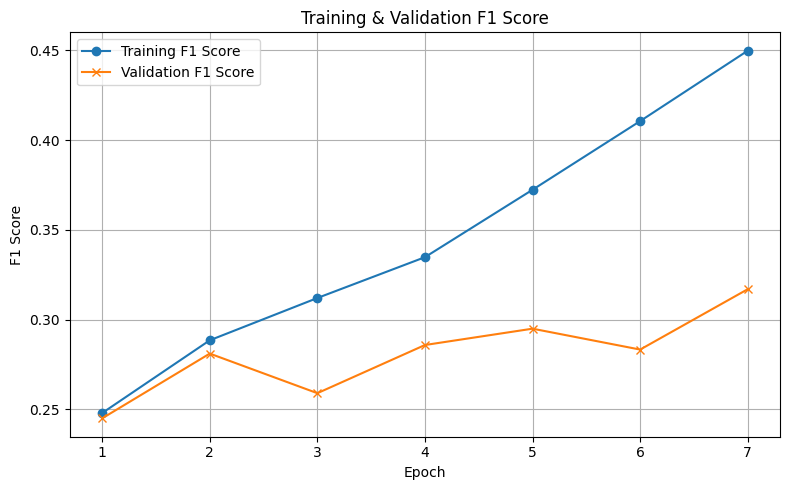

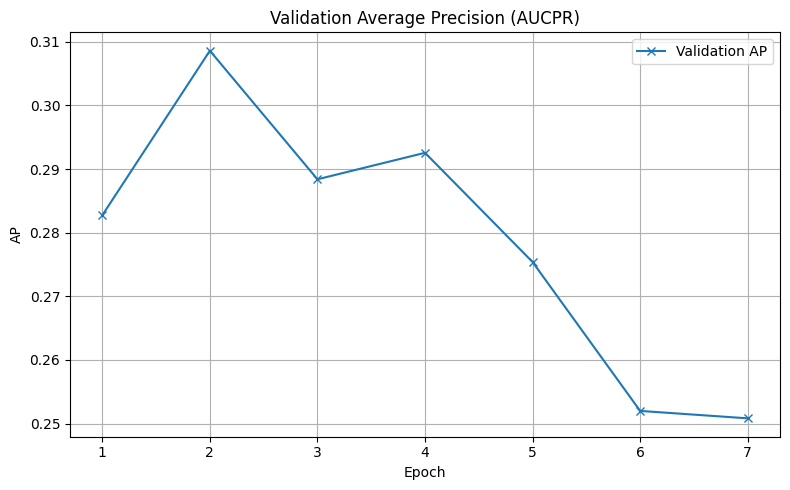

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': False, 'compact_current_team': True, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': False}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2490 | Val AP: 0.2768
Epoch 1 | Train loss: 0.9485 | Val loss: 0.5424


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2751 | Val AP: 0.3064
Epoch 2 | Train loss: 0.7866 | Val loss: 0.4513


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2545 | Val AP: 0.2962
Epoch 3 | Train loss: 0.7019 | Val loss: 0.4641
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2803 | Val AP: 0.2986
Epoch 4 | Train loss: 0.6310 | Val loss: 0.4056
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2829 | Val AP: 0.2846
Epoch 5 | Train loss: 0.5531 | Val loss: 0.4324
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2813 | Val AP: 0.2575
Epoch 6 | Train loss: 0.4817 | Val loss: 0.4232
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.3186 | Val AP: 0.2467
Epoch 7 | Train loss: 0.4220 | Val loss: 0.3616
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


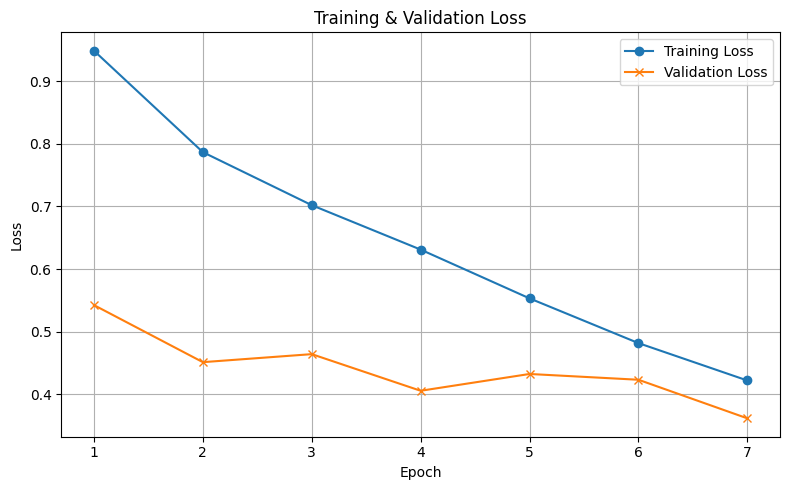

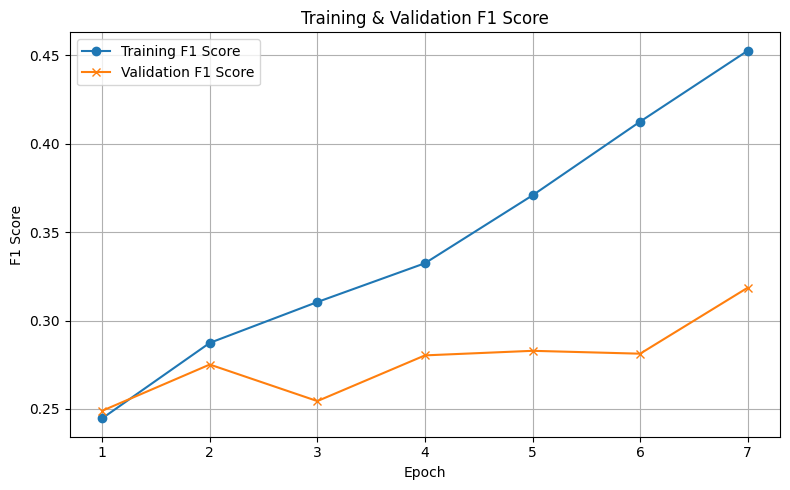

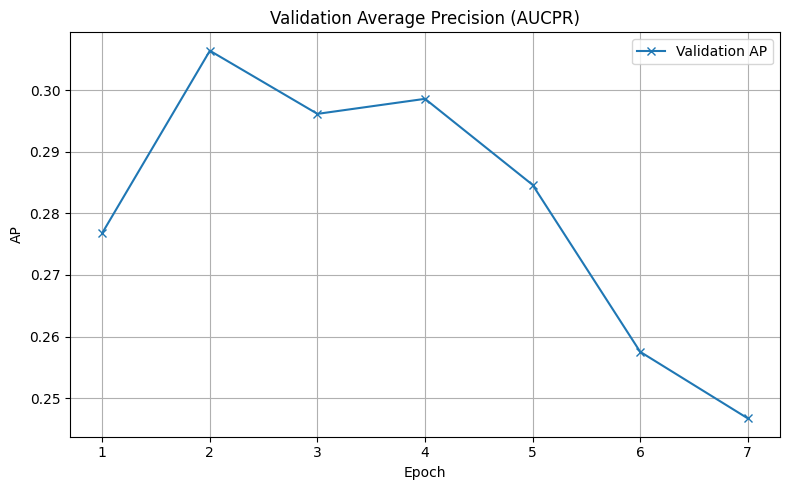

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': True, 'group_all_plays': False, 'enum_quarters': False}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2440 | Val AP: 0.2731
Epoch 1 | Train loss: 0.9504 | Val loss: 0.5516


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2734 | Val AP: 0.3068
Epoch 2 | Train loss: 0.7945 | Val loss: 0.4592


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2492 | Val AP: 0.2884
Epoch 3 | Train loss: 0.7167 | Val loss: 0.4892
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2763 | Val AP: 0.2981
Epoch 4 | Train loss: 0.6520 | Val loss: 0.4105
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2884 | Val AP: 0.2888
Epoch 5 | Train loss: 0.5775 | Val loss: 0.4147
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2746 | Val AP: 0.2757
Epoch 6 | Train loss: 0.5141 | Val loss: 0.4536
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.2962 | Val AP: 0.2395
Epoch 7 | Train loss: 0.4495 | Val loss: 0.4123
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


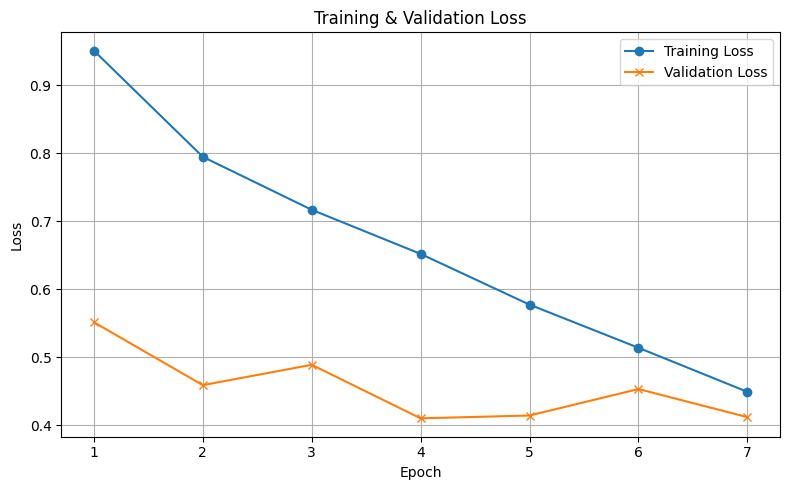

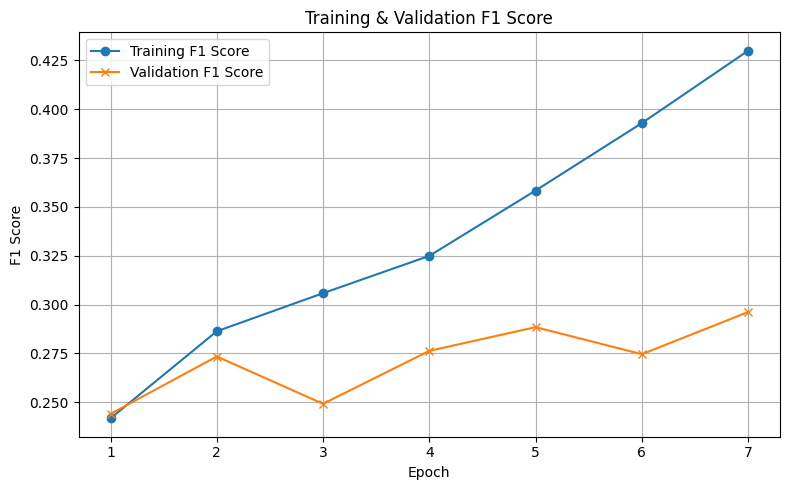

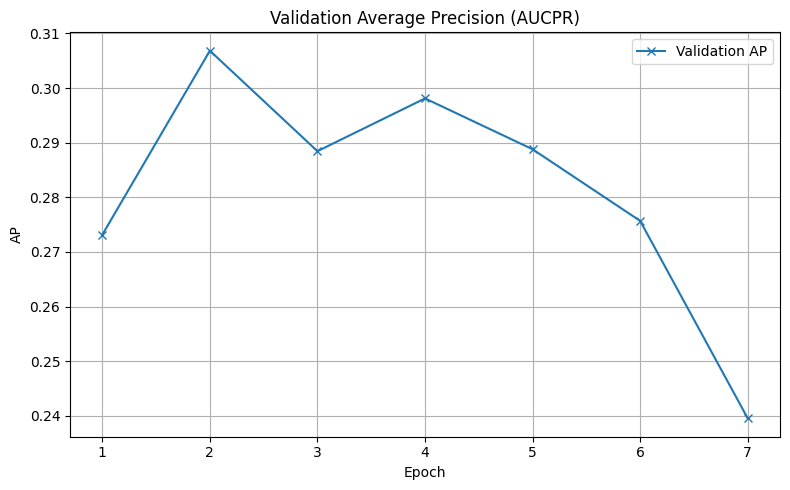

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': True, 'enum_quarters': False}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2428 | Val AP: 0.2637
Epoch 1 | Train loss: 0.9752 | Val loss: 0.5419


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2722 | Val AP: 0.2994
Epoch 2 | Train loss: 0.8286 | Val loss: 0.4551


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2608 | Val AP: 0.2781
Epoch 3 | Train loss: 0.7620 | Val loss: 0.4741
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2688 | Val AP: 0.2867
Epoch 4 | Train loss: 0.7056 | Val loss: 0.4343
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2679 | Val AP: 0.2815
Epoch 5 | Train loss: 0.6515 | Val loss: 0.4387
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2663 | Val AP: 0.2661
Epoch 6 | Train loss: 0.5960 | Val loss: 0.4619
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.2757 | Val AP: 0.2432
Epoch 7 | Train loss: 0.5464 | Val loss: 0.4403
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


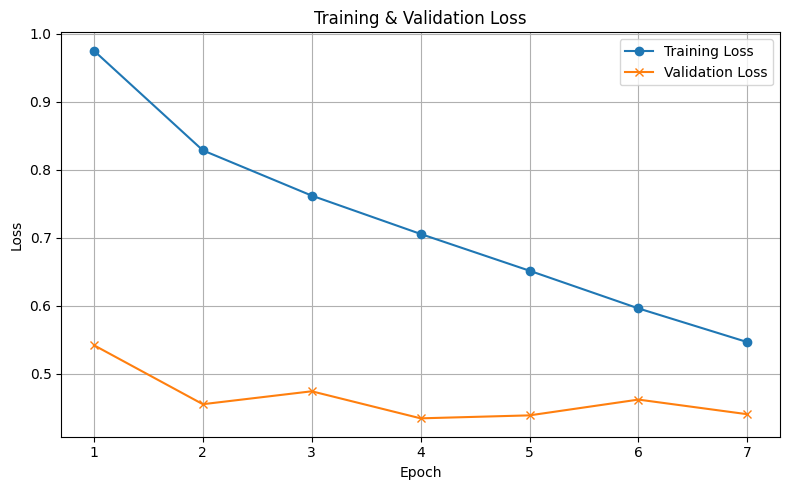

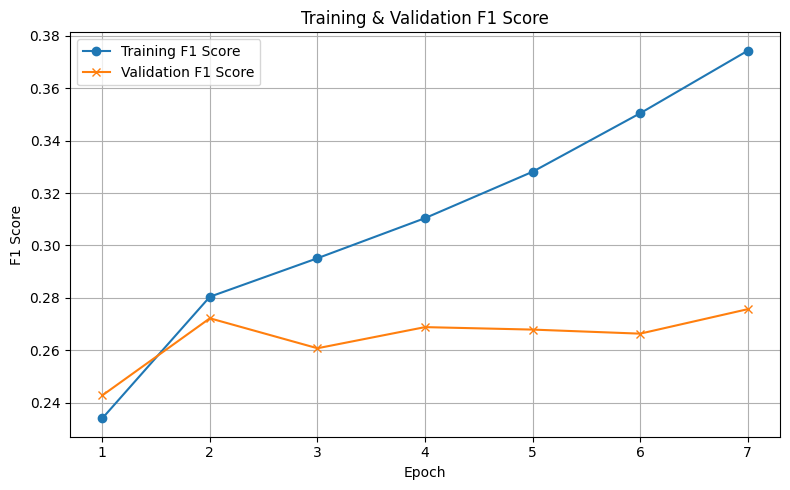

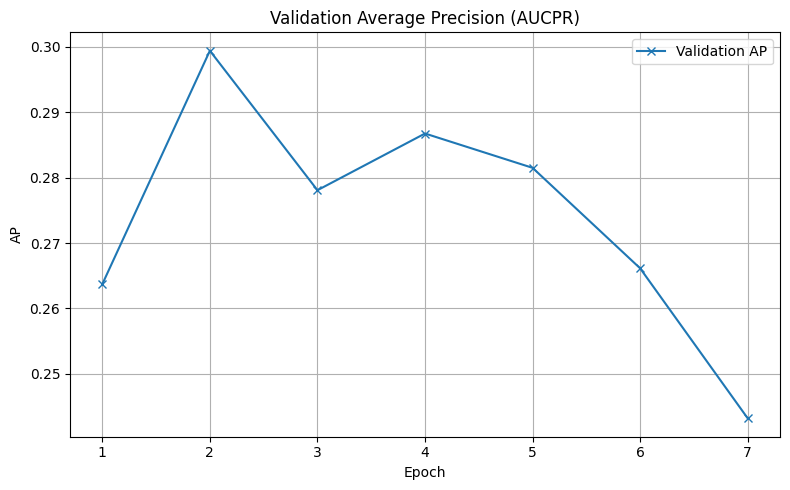

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': True}
0.001
0


epoch: 1:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Val F1: 0.2436 | Val AP: 0.2821
Epoch 1 | Train loss: 0.9500 | Val loss: 0.5501


epoch: 2:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 | Val F1: 0.2758 | Val AP: 0.3113
Epoch 2 | Train loss: 0.7843 | Val loss: 0.4540


epoch: 3:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 | Val F1: 0.2550 | Val AP: 0.2933
Epoch 3 | Train loss: 0.6969 | Val loss: 0.4596
no auprc improvement for 1 epoch(s).


epoch: 4:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 | Val F1: 0.2841 | Val AP: 0.2972
Epoch 4 | Train loss: 0.6268 | Val loss: 0.4030
no auprc improvement for 2 epoch(s).


epoch: 5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 | Val F1: 0.2957 | Val AP: 0.2751
Epoch 5 | Train loss: 0.5446 | Val loss: 0.3919
no auprc improvement for 3 epoch(s).


epoch: 6:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 | Val F1: 0.2900 | Val AP: 0.2580
Epoch 6 | Train loss: 0.4783 | Val loss: 0.4325
no auprc improvement for 4 epoch(s).


epoch: 7:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 | Val F1: 0.3059 | Val AP: 0.2364
Epoch 7 | Train loss: 0.4072 | Val loss: 0.4066
no auprc improvement for 5 epoch(s).
early stopping at epoch 7.


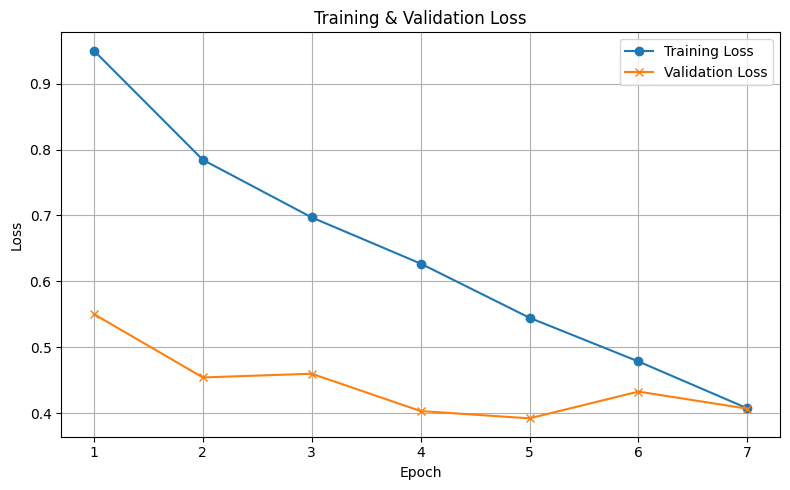

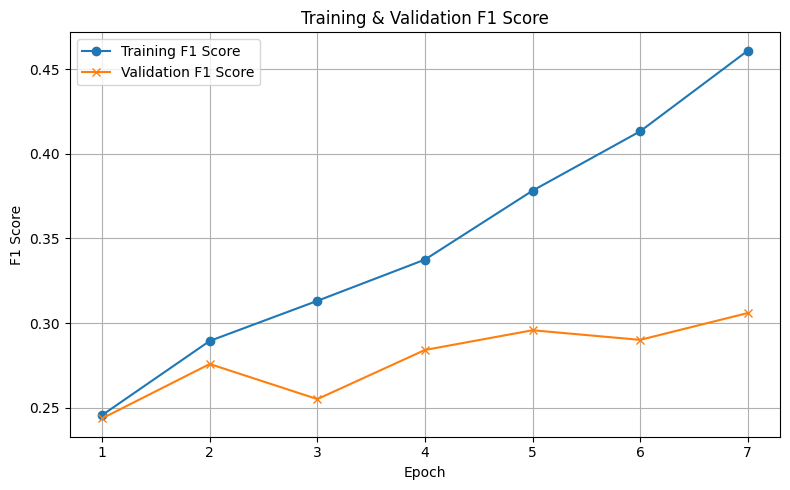

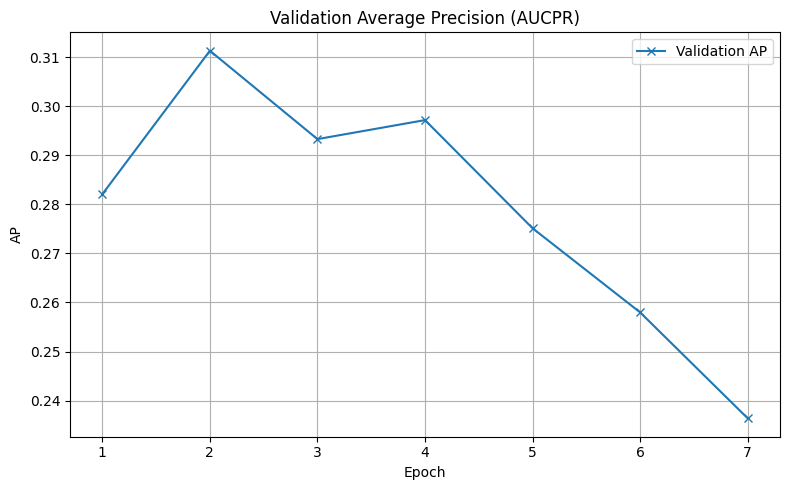

{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': False, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': False}
→ Best threshold: 0.80
accuracy    : 0.9035048177156703
precision   : 0.29012170959524486
recall      : 0.527806385169928
f1          : 0.3744292237442922
roc_auc     : 0.8603445818704274
pr_auc      : 0.3159179592993485
confusion_matrix: [[31044, 2508], [917, 1025]]
{'hidden_dims': [256, 128, 128], 'dropout': 0, 'lr': 0.001, 'epochs': 40, 'batch_size': 2048, 'weight_decay': 0, 'context_window_size': 3, 'compact_players': True, 'compact_oncourt': False, 'compact_current_team': False, 'drop_home_away_teams': False, 'group_all_plays': False, 'enum_quarters': False}
→ Best threshold: 0.80
accuracy    : 0.906632106834958
precision   : 0.3004653868528214
recall      : 0.5319258496395468
f1    

In [14]:
import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)

results = []
for params in param_grid:
    print(params)
    freeze_seeds(seed)
    
    base = add_game_ids(dataset)
    
    games_idx = base['game_id'].unique()
    
    rng = np.random.default_rng(seed=seed)  # For reproducibility
    shuffled_game_ids = rng.permutation(games_idx)
    #shuffled_game_ids
    
    split_idx = int(0.8 * len(shuffled_game_ids))
    train_game_ids = shuffled_game_ids[:split_idx]
    test_game_ids = shuffled_game_ids[split_idx:]
    split_test_ids = int(0.5 * len(test_game_ids))
    val_game_ids = test_game_ids[:split_test_ids]
    test_game_ids = test_game_ids[split_test_ids:]
    
    train_df = base[base['game_id'].isin(train_game_ids)].copy()
    val_df   = base[base['game_id'].isin(val_game_ids)].copy()
    test_df  = base[base['game_id'].isin(test_game_ids)].copy()
    
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    #ONLY for TRAIN
    sp_map = build_star_power_mapping(train_df)
    
    train_df = get_dataset(train_df, 
                 play_context_window=params['context_window_size'],
                 team_context_window=params['context_window_size'],
                 compact_players=params['compact_players'],
                 compact_oncourt=params['compact_oncourt'],
                 compact_current_team=params['compact_current_team'],
                 drop_home_away_teams=params['drop_home_away_teams'],
                 group_all_plays=params['group_all_plays'],
                 enum_quarters=params['enum_quarters'],star_power_mapping=sp_map)
    val_df = get_dataset(val_df, 
                 play_context_window=params['context_window_size'],
                 team_context_window=params['context_window_size'],
                 compact_players=params['compact_players'],
                 compact_oncourt=params['compact_oncourt'],
                 compact_current_team=params['compact_current_team'],
                 drop_home_away_teams=params['drop_home_away_teams'],
                 group_all_plays=params['group_all_plays'],
                 enum_quarters=params['enum_quarters'],star_power_mapping=sp_map)
    test_df = get_dataset(test_df, 
                 play_context_window=params['context_window_size'],
                 team_context_window=params['context_window_size'],
                 compact_players=params['compact_players'],
                 compact_oncourt=params['compact_oncourt'],
                 compact_current_team=params['compact_current_team'],
                 drop_home_away_teams=params['drop_home_away_teams'],
                 group_all_plays=params['group_all_plays'],
                 enum_quarters=params['enum_quarters'],star_power_mapping=sp_map)
    
    feature_cols = [c for c in train_df.columns if c not in LABEL_COLS]
    train_df = align_to_train(train_df, feature_cols)
    val_df = align_to_train(val_df, feature_cols)
    test_df = align_to_train(test_df, feature_cols)
    
    X_train = train_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
    y_train = train_df['is_highlight'].to_numpy(dtype=np.int32)
    X_val = val_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
    y_val = val_df['is_highlight'].to_numpy(dtype=np.int32)
    X_test = test_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
    y_test = test_df['is_highlight'].to_numpy(dtype=np.int32)
    
    scaler = StandardScaler().fit(X_train)
    
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                             torch.from_numpy(y_train).long())
    val_ds = TensorDataset(torch.from_numpy(X_val).float(),
                             torch.from_numpy(y_val).long())
    
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight_val = float(n_neg/n_pos)
    pos_weight = torch.tensor(pos_weight_val, device=device, dtype=torch.float32)
    
    
    generator = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, generator=generator)
    val_loader   = DataLoader(val_ds, batch_size=2048, shuffle=False)

    model = MLPClassifier.MLPClassifier(input_dim=X_train.shape[1], hidden_dims=params['hidden_dims'], dropout=params['dropout']).to(device)

    model = MLPClassifier.train_fold(model=model, train_loader=train_loader, val_loader=val_loader, device=device, epochs=params['epochs'], lr=params['lr'], pos_weight=pos_weight, min_delta=0, save_model=SAVE_MODEL, rm_ft_ds=REMOVE_FREETHROWS_DATASET, weight_decay=params['weight_decay'], patience=5, objective="auprc")

    result = evaluate_imbalanced(model=model,
                              loader=val_loader,
                              device=device,
                              beta=1.0,
                              thr_grid=np.linspace(0,1,201),)

    results.append(result)

for result, params in zip(results,param_grid) :
    print(params)
    print(f"→ Best threshold: {result['best_threshold']:.2f}")
    for name, val in result["metrics_at_best"].items():
        print(f"{name:12s}: {val}")


In [ ]:
logits = model(torch.tensor(X_val).to(device))
logits

In [ ]:
for result, params in zip(results,param_grid) :
    print(params)
    print(f"→ Best threshold: {result['best_threshold']:.2f}")
    for name, val in result["metrics_at_best"].items():
        print(f"{name:12s}: {val}")


# Test SMOTE

In [ ]:
dataset = pd.read_csv(data)
df = get_dataset(ds=dataset, verbose=False, rm_ft_ds=REMOVE_FREETHROWS_DATASET, add_game_idx=True,
                 play_context_window=1,
                 team_context_window=1,
                 compact_players=1,
                 compact_oncourt=1,
                 compact_current_team=1,
                 drop_home_away_teams=1,
                 group_all_plays=0,
                 enum_quarters=1)

#len(start_positions)
games_idx = df['game_id'].unique()
#len(start_positions)
#games_idx
rng = np.random.default_rng(seed=seed)  # For reproducibility
shuffled_game_ids = rng.permutation(games_idx)
shuffled_game_ids

split_idx = int(0.6 * len(shuffled_game_ids))
train_game_ids = shuffled_game_ids[:split_idx]
test_game_ids = shuffled_game_ids[split_idx:]
split_test_ids = int(0.5 * len(test_game_ids))
val_game_ids = test_game_ids[:split_test_ids]
test_game_ids = test_game_ids[split_test_ids:]
print(len(train_game_ids))
print(len(val_game_ids))
print(len(test_game_ids))

X = df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)#.values.astype(np.float32)
y = df['is_highlight'].to_numpy(dtype=np.int32)#.values.astype(int)
#print(f"start1 loading time: {time.time() - start_time_1:.2f}s")
#start_time_2 = time.time()

train_df = df[df['game_id'].isin(train_game_ids)]
val_df = df[df['game_id'].isin(val_game_ids)]
test_df = df[df['game_id'].isin(test_game_ids)]

X_train = train_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
y_train = train_df['is_highlight'].to_numpy(dtype=np.int32)
X_val = val_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
y_val = val_df['is_highlight'].to_numpy(dtype=np.int32)

X_test = test_df.drop(columns=['is_highlight', 'game_id']).to_numpy(dtype=np.float32)
y_test = test_df['is_highlight'].to_numpy(dtype=np.int32)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=seed)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [ ]:
scaler = StandardScaler().fit(X_train_bal)
X_train_bal = scaler.transform(X_train_bal)
X_val = scaler.transform(X_val)
# tensors & loaders
train_ds = TensorDataset(torch.from_numpy(X_train_bal).float(),
                         torch.from_numpy(y_train_bal).long())
val_ds   = TensorDataset(torch.from_numpy(X_val).float(),
                         torch.from_numpy(y_val).long())
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2048, shuffle=False)

In [ ]:
import MLPClassifierSMOTE

model = MLPClassifierSMOTE(input_dim=X_train_bal.shape[1], hidden_dim=32, dropout=0.5).to(device)


model = MLPClassifierSMOTE.train_fold(model=model, train_loader=train_loader, val_loader=val_loader, device=device, epochs=50, lr=1e-3, pos_weight=torch.tensor(0), min_delta=0, save_model=True, rm_ft_ds=False, weight_decay=0, patience=15)

result = evaluate_imbalanced(model=model,
                          loader=val_loader,
                          device=device,
                          beta=1.0,
                          thr_grid=np.linspace(0,1,201),)

print(f"→ Best threshold: {result['best_threshold']:.2f}")
for name, val in result["metrics_at_best"].items():
    print(f"{name:12s}: {val}")


In [ ]:
from MLPClassifierSMOTE import *

hidden_dims = [32]
dropouts    = [0.5]

best_config = None
best_val_ap = 0.0

for hd in hidden_dims:
    for do in dropouts:
        print(f"Testing hidden_dim={hd}, dropout={do}")
        model = MLPClassifierSMOTE(input_dim=X_train_bal.shape[1], hidden_dim=hd, dropout=do).to(device)

        model = train_fold(
            model       = model,
            train_loader= train_loader,
            val_loader  = val_loader,
            device      = device,
            epochs      = 20,         # fewer epochs for search
            lr          = 1e-3,
            weight_decay= 0,          # keep plain for now
            patience    = 5,
            save_model  = False
        )

        # evaluate final AP on val set
        y_t, y_p = evaluate(model, val_loader, device)
        ap = average_precision_score(y_t, y_p)
        print(f"→ hidden_dim={hd}, dropout={do} gave Val AP={ap:.3f}\n")

        if ap > best_val_ap:
            best_val_ap = ap
            best_config = (hd, do)

print(f"Best config: hidden_dim={best_config[0]}, dropout={best_config[1]} → AP={best_val_ap:.3f}")

In [ ]:
from MLPClassifierSMOTE import *
hidden_dims = [32]
dropouts    = [0.5]
best_config = None
best_val_ap = 0.0

for hd in hidden_dims:
    for do in dropouts:
        print(f"Testing hidden_dim={hd}, dropout={do}")
        model = MLPClassifierSMOTE(input_dim=X_train_bal.shape[1], hidden_dim=hd, dropout=do).to(device)

        model = train_fold(
            model       = model,
            train_loader= train_loader,
            val_loader  = val_loader,
            device      = device,
            epochs      = 50,         # fewer epochs for search
            lr          = 1e-3,
            weight_decay= 1e-3,          # keep plain for now
            patience    = 5,
            save_model  = True
        )

        # evaluate final AP on val set
        y_t, y_p = evaluate(model, val_loader, device)
        ap = average_precision_score(y_t, y_p)
        print(f"→ hidden_dim={hd}, dropout={do} gave Val AP={ap:.3f}\n")

        if ap > best_val_ap:
            best_val_ap = ap
            best_config = (hd, do)

print(f"Best config: hidden_dim={best_config[0]}, dropout={best_config[1]} → AP={best_val_ap:.3f}")